In [212]:
import cv2
import albumentations as A
from albumentations.core.composition import OneOf
import matplotlib.pyplot as plt
import numpy as np
import math

In [213]:
target_size = (3200 // 2, 2496 // 2)

In [214]:
def add_rectangle(img):
    width, height = img.shape[1], img.shape[0]
    start_point_right = (math.ceil(0.5*width), 0)
    end_point_right = (width, height)
    color = (255,255,255)
    img = cv2.rectangle(img, start_point_right, end_point_right, color, -1)
        
    start_point_left = (0, 0)
    end_point_left = (math.floor(width*0.08), height)
    img = cv2.rectangle(img, start_point_left, end_point_left, color, -1)

    return img

In [215]:
def find_vertical_line_bounds(img):
    """Find the leftmost and rightmost vertical lines in left half of image"""
    # Create a copy for vertical line detection
    vertical = np.copy(img)
    
    # Only consider left half of image
    half_width = img.shape[1] // 2
    vertical = vertical[:, :half_width]
    
    # Enhance vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical = cv2.morphologyEx(vertical, cv2.MORPH_CLOSE, vertical_kernel)
    
    # Sum along vertical axis to get column profile
    col_profile = np.sum(vertical == 0, axis=0)  # Sum black pixels
    
    # Find columns with significant vertical lines
    threshold = np.max(col_profile) * 0.3  # Adjust this threshold if needed
    line_cols = np.where(col_profile > threshold)[0]
    
    if len(line_cols) > 1:  # Make sure we have at least 2 lines
        left_bound = max(0, line_cols[0] - 10)  # Add small padding
        right_bound = min(half_width, line_cols[-1] -5)  # Use last line found in left half
        return left_bound, right_bound
    
    return 0, img.shape[1]

def find_content_bounds(img):
    """Find the top and bottom bounds of content in the image"""
    # Sum along horizontal axis to get row profile
    row_profile = np.sum(img == 0, axis=1)  # Sum black pixels
    
    # Find rows with content
    content_rows = np.where(row_profile > 0)[0]
    
    if len(content_rows) > 0:
        start_row = max(0, content_rows[0] - 10)  # Add small padding
        end_row = min(img.shape[0], content_rows[-1] + 10)
        return start_row, end_row
    
    return 0, img.shape[0]

def preprocess(img, BS=13, C=12):
    """Complete preprocessing pipeline"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Simple Gaussian blur to reduce initial noise
    img = cv2.GaussianBlur(img, (3, 3), 0)
    
    # Apply adaptive thresholding
    img = cv2.adaptiveThreshold(
        img,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        blockSize=BS,
        C=C
    )
    
    # Clean up noise
    kernel = np.ones((3,3), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Enhance vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 20))
    vertical_lines = cv2.morphologyEx(img, cv2.MORPH_CLOSE, vertical_kernel)
    
    # Combine with original binary image
    img = cv2.bitwise_and(img, vertical_lines)
    
    # Find content bounds
    start_row, end_row = find_content_bounds(img)
    
    # Find vertical line bounds
    left_bound, right_bound = find_vertical_line_bounds(img)
    
    # Make everything outside vertical lines white
    img[:, :left_bound] = 255
    img[:, right_bound:] = 255
    
    # Crop to content
    img = img[start_row:end_row, :]
    
    # Normalize and resize
    img = img.astype(float) / 255.0
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    return img

In [216]:
albumentations_transform = A.Compose([
    # Rotation - keeping this modest since text is vertical
    A.Affine(
        rotate=(-5, 0),
        p=0.6,
        mode=cv2.BORDER_CONSTANT,
        cval=1,  # Using 1 for white since image is normalized
        interpolation=cv2.INTER_NEAREST,
    ),
    
    # Shear - reduced for structural preservation
    A.Affine(
        shear=(-3, 3),
        p=0.6,
        mode=cv2.BORDER_CONSTANT,
        cval=1,
        interpolation=cv2.INTER_NEAREST,
    ),
    
    # Translation - more balanced range
    A.Affine(
        translate_percent={"x": (-0.05, 0.05)},  # Reduced y-range
        p=0.6,
        mode=cv2.BORDER_CONSTANT,
        cval=1,
        interpolation=cv2.INTER_NEAREST,
    ),
    
    # Elastic Transform - gentler settings
    A.ElasticTransform(
        alpha=50.0,
        sigma=20,
        p=0.3,
        border_mode=cv2.BORDER_CONSTANT,
        value=1,
    ),
    
    # Grid Distortion - for subtle warping
    A.GridDistortion(
        num_steps=5,
        distort_limit=0.2,
        p=0.3,
        border_mode=cv2.BORDER_CONSTANT,
        value=1,
    ),
    
    # Optical Distortion - for lens-like effects
    A.OpticalDistortion(
        distort_limit=0.2,
        shift_limit=0.2,
        p=0.3,
        border_mode=cv2.BORDER_CONSTANT,
        value=1,
    ),
])

In [217]:
albumentations_transform = A.Compose([
    # Controlled rotation
    A.Affine(
        rotate=(-1, 1),  # Very small rotation range
        p=0.3,
        mode=cv2.BORDER_CONSTANT,
        cval=255,
    ),
    
    # Minimal shear
    A.Affine(
        shear=(-1, 1),  # Reduced shear range
        p=0.3,
        mode=cv2.BORDER_CONSTANT,
        cval=255,
    ),
    
    # Column-aware translation
    A.Affine(
        translate_percent={"x": (-0.02, 0.02)},  # Reduced horizontal translation
        p=0.5,
        mode=cv2.BORDER_CONSTANT,
        cval=255,
    ),
    
    # Very subtle elastic transform
    A.ElasticTransform(
        alpha=20.0,  # Reduced strength
        sigma=8,
        p=0.2,
        border_mode=cv2.BORDER_CONSTANT,
        value=1,
    ),
], additional_targets={'mask': 'mask'})

In [218]:
def visualize_transformations(image, transform, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    
    for i in range(num_examples):
        # Apply transformation
        augmented = transform(image=image)['image']
        
        # Handle single axis case
        if num_examples == 1:
            ax = axes
        else:
            ax = axes[i]
            
        # Display the image
        # Since we're working with normalized grayscale images (0-1 float values)
        ax.imshow(augmented, cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [219]:
def compare_elastic_transforms(image):
    # Create different elastic transforms
    transforms = [
        ("Original", None),
        ("Low α=10, Low σ=10", A.ElasticTransform(alpha=10.0, sigma=10, p=1)),
        ("High α=100, Low σ=10", A.ElasticTransform(alpha=100.0, sigma=10, p=1)),
        ("Low α=10, High σ=200", A.ElasticTransform(alpha=10.0, sigma=200, p=1)),
        ("High α=100, High σ=200", A.ElasticTransform(alpha=100.0, sigma=200, p=1))
    ]
    
    # Create subplot
    fig, axes = plt.subplots(1, len(transforms), figsize=(20, 4))
    
    # Apply and display each transform
    for idx, (title, transform) in enumerate(transforms):
        if transform is None:
            # Original image
            aug_image = image
        else:
            # Apply transformation
            aug_image = transform(image=image)['image']
            
        # Display
        axes[idx].imshow(aug_image, cmap='gray', vmin=0, vmax=1)
        axes[idx].set_title(title)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [220]:
def compare_brightness_contrast(image):
    # Create different brightness/contrast combinations
    transforms = [
        ("Original", None),
        ("L:0.1", A.RandomBrightness(limit=0.1, p=1)),
        ("B:0.3", A.RandomBrightness(limit=0.3, p=1)),
    ]
    
    # Create figure and apply transforms multiple times to show randomness
    n_rows = 3  # Show multiple random applications
    fig, axes = plt.subplots(n_rows, len(transforms), figsize=(20, 4 * n_rows))
    
    for row in range(n_rows):
        for idx, (title, transform) in enumerate(transforms):
            if transform is None:
                # Original image
                aug_image = image
            else:
                # Apply transformation
                aug_image = transform(image=image)['image']
            
            # Display
            axes[row, idx].imshow(aug_image, cmap='gray', vmin=0, vmax=1)
            if row == 0:  # Only show titles on first row
                axes[row, idx].set_title(title)
            axes[row, idx].axis('off')
    
    plt.tight_layout()
    plt.show()


In [225]:
albumentations_transform = A.Compose([
    # Slight rotations for page tilt
    A.Affine(rotate=(-2, 2), p=0.9),
    
    # # Brightness/contrast variations for ink/paper aging
    # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.7),
    
    # # Gaussian noise for paper texture
    # A.GaussNoise(var_limit=(5, 20), p=0.6),
    
    # Blur for focus variations
    A.GaussianBlur(blur_limit=(3, 5), p=0.4),
    
    # Slight vertical stretching/compression
    A.Affine(scale={"y": (0.95, 1.05)}, p=0.5),
    
    # Very minimal horizontal shear
    A.Affine(shear=(-1, 1), p=0.4)
], additional_targets={'mask': 'mask'})

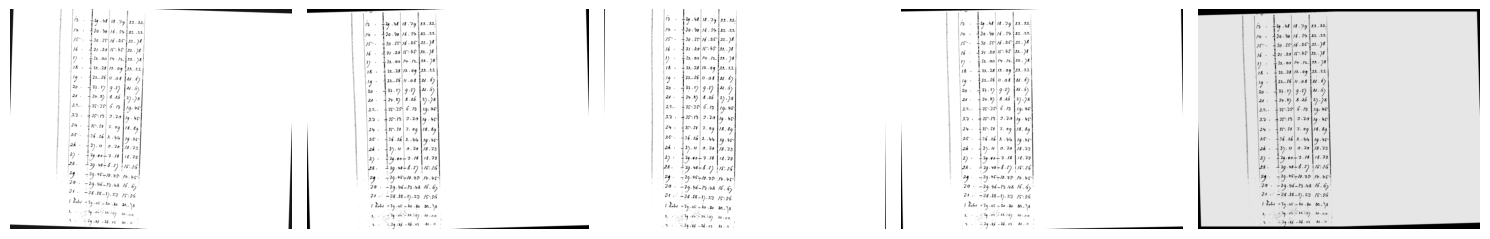

In [226]:
# Path to the image
image_path = r"..\data\processed\images\8013620831-0054.jpg-b.jpg"

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale since it's black & white
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Visualize transformations with preprocessing

img = preprocess(image)

visualize_transformations(img, albumentations_transform)
# compare_elastic_transforms(img)
# compare_brightness_contrast(img)